In [24]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
import sys

In [3]:
from plotting0 import newfig, savefig

In [4]:
print(sys.path)

['C:\\Users\\Sajjad SA\\2.DL\\Navier Stokes', 'C:\\anaconda3\\python310.zip', 'C:\\anaconda3\\DLLs', 'C:\\anaconda3\\lib', 'C:\\anaconda3', '', 'C:\\anaconda3\\lib\\site-packages', 'C:\\anaconda3\\lib\\site-packages\\win32', 'C:\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\anaconda3\\lib\\site-packages\\Pythonwin']


In [5]:
data=scipy.io.loadmat("cylinder_nektar_wake.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Sep 22 23:02:15 2017',
 '__version__': '1.0',
 '__globals__': [],
 'X_star': array([[ 1.        , -2.        ],
        [ 1.07070707, -2.        ],
        [ 1.14141414, -2.        ],
        ...,
        [ 7.85858586,  2.        ],
        [ 7.92929293,  2.        ],
        [ 8.        ,  2.        ]]),
 't': array([[ 0. ],
        [ 0.1],
        [ 0.2],
        [ 0.3],
        [ 0.4],
        [ 0.5],
        [ 0.6],
        [ 0.7],
        [ 0.8],
        [ 0.9],
        [ 1. ],
        [ 1.1],
        [ 1.2],
        [ 1.3],
        [ 1.4],
        [ 1.5],
        [ 1.6],
        [ 1.7],
        [ 1.8],
        [ 1.9],
        [ 2. ],
        [ 2.1],
        [ 2.2],
        [ 2.3],
        [ 2.4],
        [ 2.5],
        [ 2.6],
        [ 2.7],
        [ 2.8],
        [ 2.9],
        [ 3. ],
        [ 3.1],
        [ 3.2],
        [ 3.3],
        [ 3.4],
        [ 3.5],
        [ 3.6],
        [ 3.7],
        [ 

In [6]:
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

In [7]:
print(U_star.shape,P_star.shape,t_star.shape,X_star.shape)

(5000, 2, 200) (5000, 200) (200, 1) (5000, 2)


In [8]:
N = X_star.shape[0]
T = t_star.shape[0]

In [9]:
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T
    
UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

In [10]:
print(XX.shape,YY.shape,TT.shape,VV.shape,UU.shape,PP.shape)

(5000, 200) (5000, 200) (5000, 200) (5000, 200) (5000, 200) (5000, 200)


In [11]:
x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
    
u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

In [12]:
print(x.shape)

(1000000, 1)


In [13]:
N_train = 5000
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

In [14]:
print(x_train.shape)

(5000, 1)


In [25]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, u, v, layers):
        
        X = np.concatenate([x, y, t], 1)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X
        
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        
        self.u = u
        self.v = v
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_sum(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_sum(tf.square(self.f_u_pred)) + \
                    tf.reduce_sum(tf.square(self.f_v_pred))       
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        self.saver = tf.train.Saver()

        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        psi_and_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]
        
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]  
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)
        
        return u, v, p, f_u, f_v
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.u_tf: self.u, self.v_tf: self.v}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, feed_dict=tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        save_path = self.saver.save(self.sess, "model.ckpt")
        print("Model saved in path: %s" % save_path)

            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star

In [26]:
layers = [3, 20, 20, 20, 20, 2]
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)

Device mapping: no known devices.


In [27]:
model.train(10000)

It: 0, Loss: 4.921e+03, l1: 0.001, l2: -0.00100, Time: 10.46
It: 10, Loss: 3.818e+03, l1: 0.011, l2: -0.00938, Time: 2.42
It: 20, Loss: 2.853e+03, l1: 0.021, l2: -0.01308, Time: 2.02
It: 30, Loss: 1.890e+03, l1: 0.034, l2: -0.01939, Time: 1.80
It: 40, Loss: 1.281e+03, l1: 0.047, l2: -0.02541, Time: 1.75
It: 50, Loss: 1.230e+03, l1: 0.048, l2: -0.01331, Time: 1.76
It: 60, Loss: 1.151e+03, l1: 0.034, l2: -0.00040, Time: 1.71
It: 70, Loss: 1.091e+03, l1: 0.020, l2: 0.00343, Time: 1.78
It: 80, Loss: 1.052e+03, l1: 0.005, l2: 0.00263, Time: 1.76
It: 90, Loss: 1.015e+03, l1: -0.009, l2: 0.00284, Time: 1.60
It: 100, Loss: 9.860e+02, l1: -0.013, l2: 0.00640, Time: 1.69
It: 110, Loss: 9.614e+02, l1: -0.008, l2: 0.01128, Time: 1.62
It: 120, Loss: 9.378e+02, l1: 0.004, l2: 0.01520, Time: 1.51
It: 130, Loss: 9.132e+02, l1: 0.018, l2: 0.01772, Time: 1.51
It: 140, Loss: 8.862e+02, l1: 0.035, l2: 0.01915, Time: 1.58
It: 150, Loss: 8.555e+02, l1: 0.052, l2: 0.01934, Time: 1.56
It: 160, Loss: 8.202e+02

It: 1320, Loss: 4.634e+02, l1: -0.001, l2: -0.00010, Time: 1.23
It: 1330, Loss: 4.634e+02, l1: -0.000, l2: -0.00009, Time: 1.17
It: 1340, Loss: 4.633e+02, l1: -0.000, l2: -0.00009, Time: 1.23
It: 1350, Loss: 4.632e+02, l1: 0.000, l2: -0.00008, Time: 1.20
It: 1360, Loss: 4.632e+02, l1: 0.001, l2: -0.00007, Time: 1.27
It: 1370, Loss: 4.631e+02, l1: 0.001, l2: -0.00006, Time: 1.23
It: 1380, Loss: 4.631e+02, l1: 0.001, l2: -0.00006, Time: 1.21
It: 1390, Loss: 4.630e+02, l1: 0.001, l2: -0.00005, Time: 1.25
It: 1400, Loss: 4.629e+02, l1: 0.002, l2: -0.00004, Time: 1.23
It: 1410, Loss: 4.629e+02, l1: 0.002, l2: -0.00004, Time: 1.17
It: 1420, Loss: 4.628e+02, l1: 0.002, l2: -0.00003, Time: 1.20
It: 1430, Loss: 4.628e+02, l1: 0.002, l2: -0.00003, Time: 1.23
It: 1440, Loss: 4.627e+02, l1: 0.003, l2: -0.00002, Time: 1.18
It: 1450, Loss: 4.627e+02, l1: 0.003, l2: -0.00001, Time: 1.19
It: 1460, Loss: 4.626e+02, l1: 0.003, l2: -0.00001, Time: 1.22
It: 1470, Loss: 4.625e+02, l1: 0.003, l2: -0.00000, 

It: 2630, Loss: 4.538e+02, l1: 0.071, l2: 0.00198, Time: 1.26
It: 2640, Loss: 4.537e+02, l1: 0.073, l2: 0.00202, Time: 1.23
It: 2650, Loss: 4.535e+02, l1: 0.074, l2: 0.00206, Time: 1.22
It: 2660, Loss: 4.534e+02, l1: 0.075, l2: 0.00210, Time: 1.18
It: 2670, Loss: 4.533e+02, l1: 0.076, l2: 0.00214, Time: 1.25
It: 2680, Loss: 4.532e+02, l1: 0.077, l2: 0.00218, Time: 1.23
It: 2690, Loss: 4.531e+02, l1: 0.077, l2: 0.00221, Time: 1.21
It: 2700, Loss: 4.530e+02, l1: 0.078, l2: 0.00224, Time: 1.20
It: 2710, Loss: 4.529e+02, l1: 0.078, l2: 0.00226, Time: 1.25
It: 2720, Loss: 4.528e+02, l1: 0.079, l2: 0.00228, Time: 1.24
It: 2730, Loss: 4.527e+02, l1: 0.079, l2: 0.00230, Time: 1.27
It: 2740, Loss: 4.526e+02, l1: 0.079, l2: 0.00231, Time: 1.24
It: 2750, Loss: 4.526e+02, l1: 0.080, l2: 0.00232, Time: 1.30
It: 2760, Loss: 4.525e+02, l1: 0.080, l2: 0.00233, Time: 1.27
It: 2770, Loss: 4.524e+02, l1: 0.080, l2: 0.00234, Time: 1.22
It: 2780, Loss: 4.523e+02, l1: 0.080, l2: 0.00234, Time: 1.20
It: 2790

It: 3960, Loss: 8.644e+01, l1: 0.889, l2: 0.01313, Time: 1.22
It: 3970, Loss: 8.484e+01, l1: 0.891, l2: 0.01314, Time: 1.20
It: 3980, Loss: 8.370e+01, l1: 0.893, l2: 0.01304, Time: 1.20
It: 3990, Loss: 8.190e+01, l1: 0.894, l2: 0.01320, Time: 1.24
It: 4000, Loss: 8.051e+01, l1: 0.896, l2: 0.01327, Time: 1.28
It: 4010, Loss: 7.917e+01, l1: 0.897, l2: 0.01330, Time: 1.25
It: 4020, Loss: 7.789e+01, l1: 0.899, l2: 0.01333, Time: 1.29
It: 4030, Loss: 7.668e+01, l1: 0.900, l2: 0.01338, Time: 1.35
It: 4040, Loss: 7.552e+01, l1: 0.902, l2: 0.01347, Time: 1.35
It: 4050, Loss: 7.441e+01, l1: 0.903, l2: 0.01354, Time: 1.24
It: 4060, Loss: 7.374e+01, l1: 0.905, l2: 0.01359, Time: 1.25
It: 4070, Loss: 7.249e+01, l1: 0.906, l2: 0.01375, Time: 1.24
It: 4080, Loss: 7.147e+01, l1: 0.907, l2: 0.01383, Time: 1.23
It: 4090, Loss: 7.058e+01, l1: 0.908, l2: 0.01390, Time: 1.19
It: 4100, Loss: 6.973e+01, l1: 0.909, l2: 0.01400, Time: 1.23
It: 4110, Loss: 6.894e+01, l1: 0.910, l2: 0.01409, Time: 1.51
It: 4120

It: 5290, Loss: 3.243e+01, l1: 0.956, l2: 0.01491, Time: 1.22
It: 5300, Loss: 3.226e+01, l1: 0.956, l2: 0.01489, Time: 1.20
It: 5310, Loss: 3.210e+01, l1: 0.956, l2: 0.01488, Time: 1.25
It: 5320, Loss: 3.194e+01, l1: 0.956, l2: 0.01488, Time: 1.25
It: 5330, Loss: 3.203e+01, l1: 0.956, l2: 0.01497, Time: 1.25
It: 5340, Loss: 3.175e+01, l1: 0.956, l2: 0.01475, Time: 1.24
It: 5350, Loss: 3.152e+01, l1: 0.957, l2: 0.01488, Time: 1.26
It: 5360, Loss: 3.133e+01, l1: 0.957, l2: 0.01483, Time: 1.26
It: 5370, Loss: 3.118e+01, l1: 0.957, l2: 0.01477, Time: 1.22
It: 5380, Loss: 3.102e+01, l1: 0.957, l2: 0.01479, Time: 1.22
It: 5390, Loss: 3.088e+01, l1: 0.957, l2: 0.01477, Time: 1.23
It: 5400, Loss: 3.073e+01, l1: 0.958, l2: 0.01475, Time: 1.24
It: 5410, Loss: 3.059e+01, l1: 0.958, l2: 0.01475, Time: 1.21
It: 5420, Loss: 3.045e+01, l1: 0.958, l2: 0.01473, Time: 1.20
It: 5430, Loss: 3.030e+01, l1: 0.958, l2: 0.01472, Time: 1.23
It: 5440, Loss: 3.016e+01, l1: 0.958, l2: 0.01470, Time: 1.24
It: 5450

It: 6620, Loss: 2.042e+01, l1: 0.974, l2: 0.01336, Time: 1.25
It: 6630, Loss: 2.038e+01, l1: 0.974, l2: 0.01336, Time: 1.28
It: 6640, Loss: 2.072e+01, l1: 0.974, l2: 0.01342, Time: 1.24
It: 6650, Loss: 2.050e+01, l1: 0.974, l2: 0.01326, Time: 1.25
It: 6660, Loss: 2.024e+01, l1: 0.974, l2: 0.01334, Time: 1.21
It: 6670, Loss: 2.020e+01, l1: 0.975, l2: 0.01333, Time: 1.24
It: 6680, Loss: 2.013e+01, l1: 0.975, l2: 0.01330, Time: 1.24
It: 6690, Loss: 2.007e+01, l1: 0.975, l2: 0.01329, Time: 1.23
It: 6700, Loss: 2.002e+01, l1: 0.975, l2: 0.01328, Time: 1.22
It: 6710, Loss: 1.997e+01, l1: 0.975, l2: 0.01328, Time: 1.29
It: 6720, Loss: 1.992e+01, l1: 0.975, l2: 0.01327, Time: 1.31
It: 6730, Loss: 1.987e+01, l1: 0.975, l2: 0.01326, Time: 1.25
It: 6740, Loss: 1.982e+01, l1: 0.975, l2: 0.01325, Time: 1.23
It: 6750, Loss: 1.978e+01, l1: 0.975, l2: 0.01324, Time: 1.23
It: 6760, Loss: 1.973e+01, l1: 0.975, l2: 0.01323, Time: 1.23
It: 6770, Loss: 1.968e+01, l1: 0.975, l2: 0.01322, Time: 1.31
It: 6780

It: 7950, Loss: 1.527e+01, l1: 0.979, l2: 0.01239, Time: 1.24
It: 7960, Loss: 1.520e+01, l1: 0.979, l2: 0.01237, Time: 1.25
It: 7970, Loss: 1.518e+01, l1: 0.979, l2: 0.01236, Time: 1.28
It: 7980, Loss: 1.515e+01, l1: 0.979, l2: 0.01236, Time: 1.19
It: 7990, Loss: 1.513e+01, l1: 0.979, l2: 0.01236, Time: 1.27
It: 8000, Loss: 1.510e+01, l1: 0.979, l2: 0.01235, Time: 1.25
It: 8010, Loss: 1.508e+01, l1: 0.979, l2: 0.01235, Time: 1.23
It: 8020, Loss: 1.505e+01, l1: 0.979, l2: 0.01234, Time: 1.21
It: 8030, Loss: 1.503e+01, l1: 0.979, l2: 0.01234, Time: 1.23
It: 8040, Loss: 1.501e+01, l1: 0.979, l2: 0.01233, Time: 1.24
It: 8050, Loss: 1.498e+01, l1: 0.979, l2: 0.01233, Time: 1.22
It: 8060, Loss: 1.496e+01, l1: 0.979, l2: 0.01233, Time: 1.22
It: 8070, Loss: 1.528e+01, l1: 0.979, l2: 0.01238, Time: 1.26
It: 8080, Loss: 1.497e+01, l1: 0.979, l2: 0.01232, Time: 1.26
It: 8090, Loss: 1.493e+01, l1: 0.979, l2: 0.01231, Time: 1.25
It: 8100, Loss: 1.488e+01, l1: 0.979, l2: 0.01231, Time: 1.24
It: 8110

It: 9280, Loss: 1.304e+01, l1: 0.980, l2: 0.01209, Time: 1.23
It: 9290, Loss: 1.346e+01, l1: 0.980, l2: 0.01212, Time: 1.23
It: 9300, Loss: 1.313e+01, l1: 0.980, l2: 0.01214, Time: 1.22
It: 9310, Loss: 1.307e+01, l1: 0.980, l2: 0.01211, Time: 1.33
It: 9320, Loss: 1.301e+01, l1: 0.980, l2: 0.01210, Time: 1.59
It: 9330, Loss: 1.298e+01, l1: 0.980, l2: 0.01210, Time: 1.58
It: 9340, Loss: 1.296e+01, l1: 0.980, l2: 0.01209, Time: 1.58
It: 9350, Loss: 1.295e+01, l1: 0.980, l2: 0.01208, Time: 1.41
It: 9360, Loss: 1.294e+01, l1: 0.981, l2: 0.01209, Time: 1.38
It: 9370, Loss: 1.293e+01, l1: 0.981, l2: 0.01208, Time: 1.48
It: 9380, Loss: 1.292e+01, l1: 0.981, l2: 0.01208, Time: 1.44
It: 9390, Loss: 1.291e+01, l1: 0.981, l2: 0.01208, Time: 1.43
It: 9400, Loss: 1.291e+01, l1: 0.981, l2: 0.01207, Time: 1.37
It: 9410, Loss: 1.328e+01, l1: 0.981, l2: 0.01199, Time: 1.27
It: 9420, Loss: 1.301e+01, l1: 0.980, l2: 0.01212, Time: 1.24
It: 9430, Loss: 1.298e+01, l1: 0.981, l2: 0.01203, Time: 1.28
It: 9440

In [28]:
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]
    
u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

In [29]:
u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

In [30]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)

In [31]:
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

In [32]:
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - 0.01)/0.01 * 100

In [33]:
print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 2.657011e-02
Error v: 9.380693e-02
Error p: 1.381742e+01
Error l1: 1.88569%
Error l2: 20.03560%


In [34]:
def plot_solution(X_star, u_star, index):
    
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

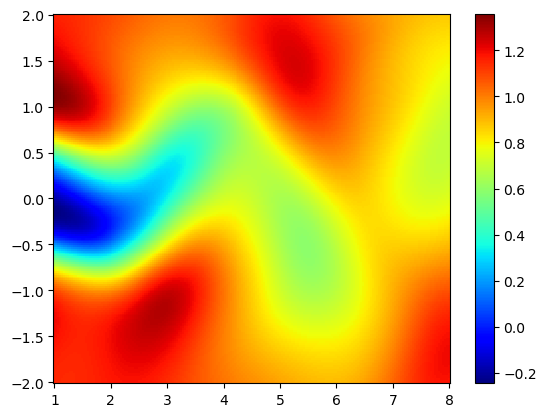

In [68]:
plot_solution(X_star, u_pred, 1)

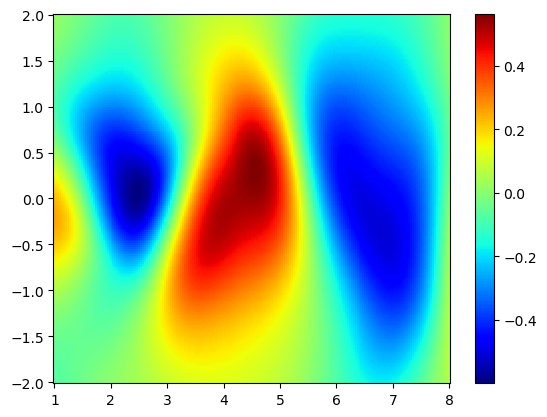

In [65]:
plot_solution(X_star, v_pred, 2)

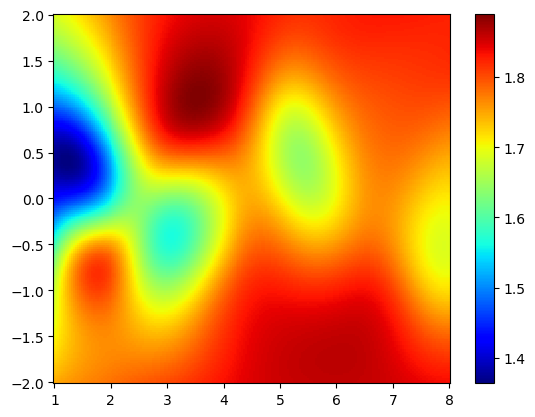

In [66]:
plot_solution(X_star, p_pred, 3)  

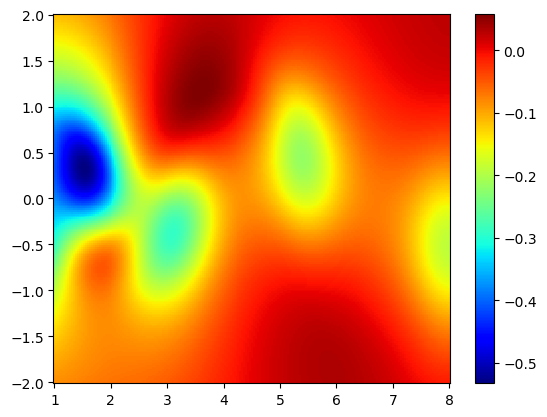

In [67]:
plot_solution(X_star, p_star, 4)

In [1]:
#plot_solution(X_star, p_star - p_pred, 5)

In [2]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [36]:
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

# NOISY DATA

In [1]:
UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

NameError: name 'griddata' is not defined

In [52]:
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
v_train = v_train + noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])   

In [55]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, u, v, layers):
        
        X = np.concatenate([x, y, t], 1)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X
        
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]
        
        self.u = u
        self.v = v
        
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_sum(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_sum(tf.square(self.f_u_pred)) + \
                    tf.reduce_sum(tf.square(self.f_v_pred))       
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        self.saver = tf.train.Saver()

        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        psi_and_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]
        
        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]  
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)
        
        return u, v, p, f_u, f_v
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.u_tf: self.u, self.v_tf: self.v}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, feed_dict=tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        save_path = self.saver.save(self.sess, "model_noisy.ckpt")
        print("Model saved in path: %s" % save_path)

            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star

In [56]:
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
model.train(10000)

Device mapping: no known devices.
It: 0, Loss: 4.614e+03, l1: 0.001, l2: -0.00100, Time: 3.73
It: 10, Loss: 3.607e+03, l1: -0.000, l2: -0.00785, Time: 1.62
It: 20, Loss: 2.676e+03, l1: -0.009, l2: -0.01819, Time: 1.88
It: 30, Loss: 1.817e+03, l1: -0.002, l2: -0.02918, Time: 1.87
It: 40, Loss: 1.361e+03, l1: 0.011, l2: -0.02354, Time: 1.87
It: 50, Loss: 1.249e+03, l1: 0.026, l2: -0.00897, Time: 2.06
It: 60, Loss: 1.137e+03, l1: 0.043, l2: 0.00570, Time: 1.86
It: 70, Loss: 1.076e+03, l1: 0.056, l2: 0.01628, Time: 1.67
It: 80, Loss: 1.018e+03, l1: 0.060, l2: 0.02073, Time: 1.70
It: 90, Loss: 9.734e+02, l1: 0.054, l2: 0.02075, Time: 1.71
It: 100, Loss: 9.336e+02, l1: 0.046, l2: 0.02047, Time: 2.62
It: 110, Loss: 8.955e+02, l1: 0.039, l2: 0.02139, Time: 3.39
It: 120, Loss: 8.566e+02, l1: 0.030, l2: 0.02220, Time: 2.94
It: 130, Loss: 8.158e+02, l1: 0.017, l2: 0.02212, Time: 2.79
It: 140, Loss: 7.730e+02, l1: 0.005, l2: 0.02137, Time: 2.80
It: 150, Loss: 7.299e+02, l1: -0.005, l2: 0.02009, Ti

It: 1310, Loss: 4.658e+02, l1: -0.015, l2: 0.00006, Time: 3.10
It: 1320, Loss: 4.657e+02, l1: -0.015, l2: 0.00006, Time: 2.91
It: 1330, Loss: 4.657e+02, l1: -0.015, l2: 0.00007, Time: 2.92
It: 1340, Loss: 4.657e+02, l1: -0.014, l2: 0.00008, Time: 2.93
It: 1350, Loss: 4.656e+02, l1: -0.014, l2: 0.00009, Time: 3.62
It: 1360, Loss: 4.656e+02, l1: -0.014, l2: 0.00009, Time: 3.10
It: 1370, Loss: 4.655e+02, l1: -0.014, l2: 0.00010, Time: 2.77
It: 1380, Loss: 4.655e+02, l1: -0.013, l2: 0.00011, Time: 2.77
It: 1390, Loss: 4.655e+02, l1: -0.013, l2: 0.00012, Time: 2.84
It: 1400, Loss: 4.654e+02, l1: -0.013, l2: 0.00012, Time: 3.43
It: 1410, Loss: 4.654e+02, l1: -0.013, l2: 0.00013, Time: 3.07
It: 1420, Loss: 4.654e+02, l1: -0.012, l2: 0.00014, Time: 2.76
It: 1430, Loss: 4.653e+02, l1: -0.012, l2: 0.00015, Time: 2.77
It: 1440, Loss: 4.653e+02, l1: -0.012, l2: 0.00015, Time: 2.76
It: 1450, Loss: 4.653e+02, l1: -0.012, l2: 0.00016, Time: 3.36
It: 1460, Loss: 4.652e+02, l1: -0.011, l2: 0.00017, Tim

It: 2620, Loss: 4.596e+02, l1: 0.011, l2: 0.00055, Time: 7.02
It: 2630, Loss: 4.596e+02, l1: 0.012, l2: 0.00057, Time: 6.07
It: 2640, Loss: 4.595e+02, l1: 0.013, l2: 0.00059, Time: 5.81
It: 2650, Loss: 4.595e+02, l1: 0.013, l2: 0.00061, Time: 6.77
It: 2660, Loss: 4.594e+02, l1: 0.014, l2: 0.00062, Time: 4.47
It: 2670, Loss: 4.593e+02, l1: 0.015, l2: 0.00064, Time: 6.29
It: 2680, Loss: 4.593e+02, l1: 0.015, l2: 0.00066, Time: 6.74
It: 2690, Loss: 4.592e+02, l1: 0.016, l2: 0.00068, Time: 5.25
It: 2700, Loss: 4.592e+02, l1: 0.017, l2: 0.00070, Time: 6.99
It: 2710, Loss: 4.591e+02, l1: 0.018, l2: 0.00072, Time: 5.59
It: 2720, Loss: 4.591e+02, l1: 0.018, l2: 0.00073, Time: 6.37
It: 2730, Loss: 4.590e+02, l1: 0.019, l2: 0.00075, Time: 6.86
It: 2740, Loss: 4.589e+02, l1: 0.020, l2: 0.00077, Time: 5.12
It: 2750, Loss: 4.589e+02, l1: 0.020, l2: 0.00079, Time: 7.09
It: 2760, Loss: 4.588e+02, l1: 0.021, l2: 0.00080, Time: 5.71
It: 2770, Loss: 4.588e+02, l1: 0.022, l2: 0.00082, Time: 6.28
It: 2780

It: 3950, Loss: 1.737e+02, l1: 0.866, l2: 0.01389, Time: 3.83
It: 3960, Loss: 1.676e+02, l1: 0.868, l2: 0.01373, Time: 3.39
It: 3970, Loss: 1.619e+02, l1: 0.870, l2: 0.01339, Time: 3.10
It: 3980, Loss: 1.547e+02, l1: 0.872, l2: 0.01339, Time: 3.24
It: 3990, Loss: 1.481e+02, l1: 0.873, l2: 0.01326, Time: 3.83
It: 4000, Loss: 1.412e+02, l1: 0.875, l2: 0.01311, Time: 3.48
It: 4010, Loss: 1.338e+02, l1: 0.876, l2: 0.01295, Time: 2.83
It: 4020, Loss: 1.276e+02, l1: 0.877, l2: 0.01310, Time: 2.99
It: 4030, Loss: 1.213e+02, l1: 0.878, l2: 0.01305, Time: 3.05
It: 4040, Loss: 1.158e+02, l1: 0.879, l2: 0.01309, Time: 3.49
It: 4050, Loss: 1.109e+02, l1: 0.881, l2: 0.01318, Time: 3.33
It: 4060, Loss: 1.066e+02, l1: 0.882, l2: 0.01325, Time: 2.86
It: 4070, Loss: 1.028e+02, l1: 0.884, l2: 0.01330, Time: 3.00
It: 4080, Loss: 1.009e+02, l1: 0.885, l2: 0.01342, Time: 2.94
It: 4090, Loss: 9.676e+01, l1: 0.887, l2: 0.01338, Time: 3.98
It: 4100, Loss: 9.410e+01, l1: 0.889, l2: 0.01336, Time: 3.33
It: 4110

It: 5280, Loss: 4.227e+01, l1: 0.947, l2: 0.01494, Time: 3.63
It: 5290, Loss: 4.209e+01, l1: 0.947, l2: 0.01494, Time: 3.64
It: 5300, Loss: 4.191e+01, l1: 0.947, l2: 0.01494, Time: 3.34
It: 5310, Loss: 4.173e+01, l1: 0.948, l2: 0.01495, Time: 3.27
It: 5320, Loss: 4.155e+01, l1: 0.948, l2: 0.01496, Time: 3.39
It: 5330, Loss: 4.138e+01, l1: 0.948, l2: 0.01495, Time: 3.67
It: 5340, Loss: 4.141e+01, l1: 0.948, l2: 0.01488, Time: 3.09
It: 5350, Loss: 4.109e+01, l1: 0.948, l2: 0.01503, Time: 3.04
It: 5360, Loss: 4.097e+01, l1: 0.949, l2: 0.01492, Time: 3.07
It: 5370, Loss: 4.073e+01, l1: 0.949, l2: 0.01494, Time: 3.55
It: 5380, Loss: 4.052e+01, l1: 0.949, l2: 0.01499, Time: 3.77
It: 5390, Loss: 4.036e+01, l1: 0.949, l2: 0.01501, Time: 3.21
It: 5400, Loss: 4.019e+01, l1: 0.950, l2: 0.01499, Time: 2.90
It: 5410, Loss: 4.003e+01, l1: 0.950, l2: 0.01499, Time: 2.86
It: 5420, Loss: 3.986e+01, l1: 0.950, l2: 0.01500, Time: 3.68
It: 5430, Loss: 3.970e+01, l1: 0.950, l2: 0.01500, Time: 3.85
It: 5440

It: 6610, Loss: 2.699e+01, l1: 0.966, l2: 0.01450, Time: 2.80
It: 6620, Loss: 2.693e+01, l1: 0.967, l2: 0.01449, Time: 2.77
It: 6630, Loss: 2.687e+01, l1: 0.967, l2: 0.01448, Time: 3.04
It: 6640, Loss: 2.683e+01, l1: 0.967, l2: 0.01449, Time: 3.47
It: 6650, Loss: 2.766e+01, l1: 0.966, l2: 0.01454, Time: 2.91
It: 6660, Loss: 2.703e+01, l1: 0.967, l2: 0.01440, Time: 2.89
It: 6670, Loss: 2.667e+01, l1: 0.967, l2: 0.01445, Time: 3.00
It: 6680, Loss: 2.663e+01, l1: 0.967, l2: 0.01446, Time: 3.13
It: 6690, Loss: 2.654e+01, l1: 0.967, l2: 0.01445, Time: 3.60
It: 6700, Loss: 2.649e+01, l1: 0.967, l2: 0.01442, Time: 2.82
It: 6710, Loss: 2.643e+01, l1: 0.967, l2: 0.01442, Time: 2.86
It: 6720, Loss: 2.638e+01, l1: 0.967, l2: 0.01442, Time: 2.82
It: 6730, Loss: 2.633e+01, l1: 0.967, l2: 0.01441, Time: 2.95
It: 6740, Loss: 2.628e+01, l1: 0.967, l2: 0.01439, Time: 3.48
It: 6750, Loss: 2.646e+01, l1: 0.967, l2: 0.01431, Time: 3.16
It: 6760, Loss: 2.625e+01, l1: 0.967, l2: 0.01443, Time: 2.80
It: 6770

It: 7940, Loss: 2.176e+01, l1: 0.972, l2: 0.01365, Time: 3.15
It: 7950, Loss: 2.173e+01, l1: 0.972, l2: 0.01363, Time: 3.32
It: 7960, Loss: 2.170e+01, l1: 0.972, l2: 0.01363, Time: 3.73
It: 7970, Loss: 2.167e+01, l1: 0.972, l2: 0.01363, Time: 3.19
It: 7980, Loss: 2.164e+01, l1: 0.972, l2: 0.01362, Time: 3.11
It: 7990, Loss: 2.162e+01, l1: 0.972, l2: 0.01362, Time: 3.10
It: 8000, Loss: 2.159e+01, l1: 0.973, l2: 0.01361, Time: 3.62
It: 8010, Loss: 2.158e+01, l1: 0.973, l2: 0.01359, Time: 3.64
It: 8020, Loss: 2.231e+01, l1: 0.972, l2: 0.01348, Time: 3.07
It: 8030, Loss: 2.151e+01, l1: 0.972, l2: 0.01362, Time: 3.02
It: 8040, Loss: 2.155e+01, l1: 0.973, l2: 0.01365, Time: 3.04
It: 8050, Loss: 2.146e+01, l1: 0.973, l2: 0.01362, Time: 3.80
It: 8060, Loss: 2.143e+01, l1: 0.973, l2: 0.01358, Time: 3.46
It: 8070, Loss: 2.140e+01, l1: 0.973, l2: 0.01358, Time: 3.27
It: 8080, Loss: 2.137e+01, l1: 0.973, l2: 0.01358, Time: 3.17
It: 8090, Loss: 2.137e+01, l1: 0.973, l2: 0.01357, Time: 3.40
It: 8100

It: 9270, Loss: 1.899e+01, l1: 0.976, l2: 0.01332, Time: 3.08
It: 9280, Loss: 1.880e+01, l1: 0.976, l2: 0.01329, Time: 3.05
It: 9290, Loss: 1.879e+01, l1: 0.976, l2: 0.01328, Time: 3.51
It: 9300, Loss: 1.877e+01, l1: 0.976, l2: 0.01330, Time: 3.72
It: 9310, Loss: 1.874e+01, l1: 0.976, l2: 0.01329, Time: 3.16
It: 9320, Loss: 1.872e+01, l1: 0.976, l2: 0.01329, Time: 3.33
It: 9330, Loss: 1.872e+01, l1: 0.976, l2: 0.01330, Time: 2.95
It: 9340, Loss: 1.913e+01, l1: 0.976, l2: 0.01339, Time: 3.80
It: 9350, Loss: 1.887e+01, l1: 0.976, l2: 0.01322, Time: 3.74
It: 9360, Loss: 1.869e+01, l1: 0.976, l2: 0.01332, Time: 3.09
It: 9370, Loss: 1.864e+01, l1: 0.976, l2: 0.01329, Time: 3.21
It: 9380, Loss: 1.863e+01, l1: 0.976, l2: 0.01326, Time: 3.61
It: 9390, Loss: 1.861e+01, l1: 0.976, l2: 0.01328, Time: 3.65
It: 9400, Loss: 1.859e+01, l1: 0.976, l2: 0.01327, Time: 3.20
It: 9410, Loss: 1.857e+01, l1: 0.976, l2: 0.01328, Time: 3.06
It: 9420, Loss: 1.855e+01, l1: 0.976, l2: 0.01327, Time: 3.00
It: 9430

In [57]:
lambda_1_value_noisy = model.sess.run(model.lambda_1)
lambda_2_value_noisy = model.sess.run(model.lambda_2)
      
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.01)/0.01 * 100
        
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))   

Error l1: 2.28999%
Error l2: 31.84084%


In [38]:
data_vort = scipy.io.loadmat('cylinder_nektar_t0_vorticity.mat')
data_vort

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Oct 20 01:01:08 2017',
 '__version__': '1.0',
 '__globals__': [],
 'modes': array([[10]], dtype=uint8),
 'nel': array([[412]], dtype=uint16),
 'w': array([[ 1.01820986e+00,  1.18381031e+00,  1.58647128e+00, ...,
         -1.88201678e-05, -1.86635701e-05, -1.86176834e-05]]),
 'x': array([[ 0.191328  ,  0.18532631,  0.17161612, ..., -6.09884175,
         -6.09844286, -6.09826678]]),
 'y': array([[-0.461945  , -0.46438536, -0.46962489, ...,  0.02748659,
          0.02982698,  0.03086004]])}

In [39]:
x_vort = data_vort['x'] 
y_vort = data_vort['y'] 
w_vort = data_vort['w'] 

In [40]:
modes = data_vort['modes'].item()
nel = data_vort['nel'].item()

In [41]:
xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')

(0.0, 1.0, 0.0, 1.0)

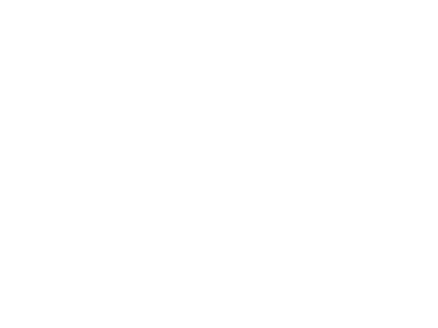

In [42]:
box_lb = np.array([1.0, -2.0])
box_ub = np.array([8.0, 2.0])
    
fig, ax = newfig(1.0, 1.2)
ax.axis('off')

Text(0.5, 1.0, 'Vorticity')

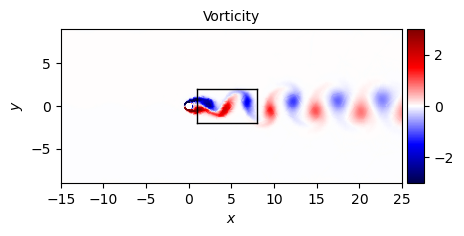

In [43]:

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])
    
for i in range(0, nel):
    h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
    
ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)
    
ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Vorticity', fontsize = 10)

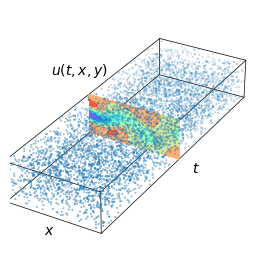

In [44]:
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]       
r3 = [y_star.min(), y_star.max()]
    
for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)
ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

(0.0, 1.0, 0.0, 1.0)

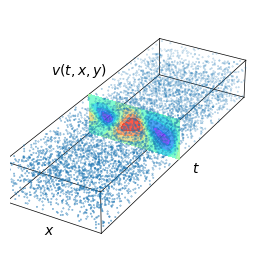

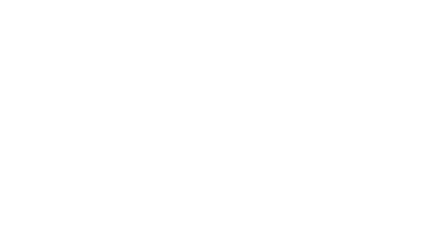

In [45]:
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')
    
r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]       
r3 = [y_star.min(), y_star.max()]
    
for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)
ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)
    
# savefig('./figures/NavierStokes_data') 

    
fig, ax = newfig(1.015, 0.8)
ax.axis('off')

Text(0.5, 1.0, 'Predicted pressure')

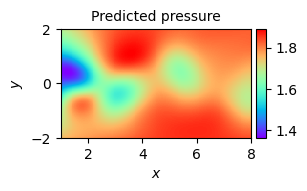

In [46]:
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)

Text(0.5, 1.0, 'Exact pressure')

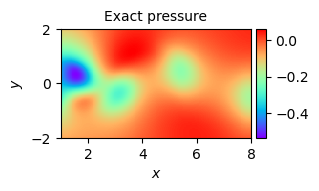

In [47]:
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 10)

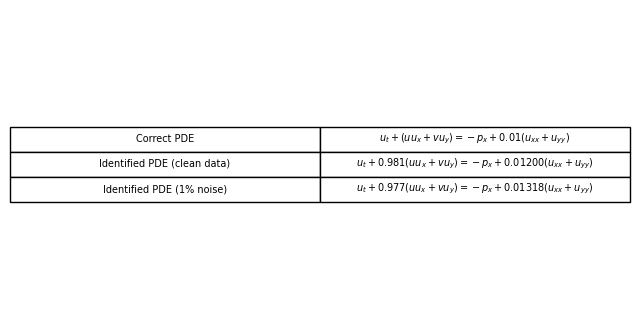

In [63]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 4))

lambda_1_value_scalar = lambda_1_value.item()
lambda_2_value_scalar = lambda_2_value.item()
lambda_1_value_noisy_scalar = lambda_1_value_noisy.item()
lambda_2_value_noisy_scalar = lambda_2_value_noisy.item()

table_data = [
    ['Correct PDE', r'$u_t + (u u_x + v u_y) = -p_x + 0.01 (u_{xx} + u_{yy})$'],
    ['Identified PDE (clean data)', r'$u_t + {:.3f} (u u_x + v u_y) = -p_x + {:.5f} (u_{{xx}} + u_{{yy}})$'.format(lambda_1_value_scalar, lambda_2_value_scalar)],
    ['Identified PDE (1% noise)', r'$u_t + {:.3f} (u u_x + v u_y) = -p_x + {:.5f} (u_{{xx}} + u_{{yy}})$'.format(lambda_1_value_noisy_scalar, lambda_2_value_noisy_scalar)]
]

table = ax.table(cellText=table_data, cellLoc='center', loc='center')
table.set_fontsize(14)
table.scale(1, 1.5)

ax.axis('off')

plt.show()



